<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Working With Time Series Data

## Icebreaker

With your neighbour discuss a couple of examples of time series data.

What makes the problem of forecasting time series different from predicting a value with linear regression?

## Housekeeping

- Unit 3 project due tomorrow

- Final presentations on **10th and 12th July**

# Introduction to Time Series

Time series are represented as a set of observations that are evenly-spaced in time

They're used to understand trends, temporal patterns, and make forecasts

What is a "trend"?

### Trends

- a long-term change in a value we're measuring (sales "are going up")

What's the difference between **trend** and **seasonality**?

### Seasonality

- deals with **cyclical** changes in a time series

- "caused" by another variable outside of the time series

### Case study: Rossmann sales

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('assets/data/rossmann.csv.gz',
                 skipinitialspace=True, # in case there are spaces after delimiters
                 low_memory=False # doesn't process data in "chunks" and therefore doesn't mix types
                )
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


There are over 1000 stores' sales listed, we'll focus on one for now...

In [2]:
df_single = df[df["Store"] == 1].copy()

What do we need to do to plot?

In [3]:
# good idea to convert to DateTime column
df_single["Date"] = pd.to_datetime(df_single["Date"])
df_single["Date"].head()

0      2015-07-31
1115   2015-07-30
2230   2015-07-29
3345   2015-07-28
4460   2015-07-27
Name: Date, dtype: datetime64[ns]

In [5]:
# extract year and month columns for use later
df_single["Year"] = df_single["Date"].dt.year
df_single["Month"] = df_single["Date"].dt.month

df_single_open = df_single[df_single["Open"] == 1].set_index("Date")
df_single_open.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-30,1,4,5020,546,1,1,0,1,2015,7
2015-07-29,1,3,4782,523,1,1,0,1,2015,7
2015-07-28,1,2,5011,560,1,1,0,1,2015,7
2015-07-27,1,1,6102,612,1,1,0,1,2015,7


Setting the `DateTime` column as the index lets us manipulate the date part more easily later

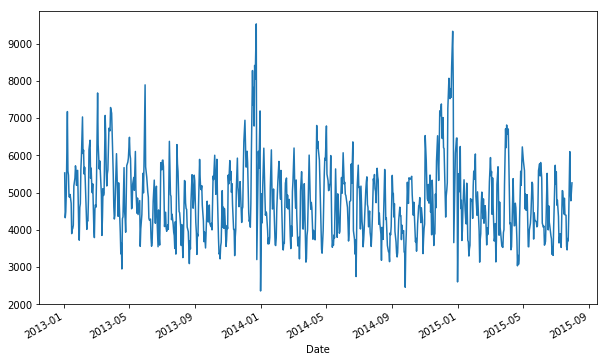

In [6]:
df_single_open["Sales"].plot(figsize=(10, 6));

Eyeballing it - what do we think about trend and seasonality?

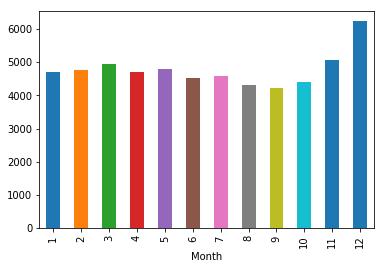

In [6]:
df_single_open.groupby("Month")["Sales"].mean().plot.bar();

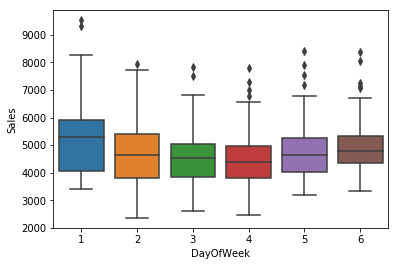

In [7]:
sns.boxplot("DayOfWeek", "Sales", data=df_single_open);

Sometimes the simple things are useful!

We can also get this data using `.resample()` (this is where the `DateTimeIndex` is useful)

In [8]:
# "M" is "month end"
df_single_open.resample("M")["Sales"].mean().head()

Date
2013-01-31    4939.653846
2013-02-28    5219.625000
2013-03-31    5806.760000
2013-04-30    4720.360000
2013-05-31    5140.217391
Freq: M, Name: Sales, dtype: float64

In [9]:
# "MS" is "month start"
df_single_open.resample("MS")["Sales"].mean().head()

Date
2013-01-01    4939.653846
2013-02-01    5219.625000
2013-03-01    5806.760000
2013-04-01    4720.360000
2013-05-01    5140.217391
Freq: MS, Name: Sales, dtype: float64

Read about your `.resample()` options here: [http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases)

What would this aggregation give us when we plot?

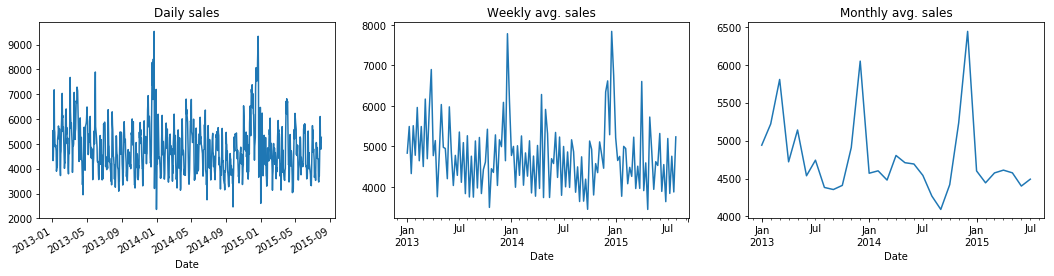

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
df_single_open["Sales"].plot(ax=ax[0], title="Daily sales")
df_single_open.resample("W")["Sales"].mean().plot(ax=ax[1], title="Weekly avg. sales")
df_single_open.resample("MS")["Sales"].mean().plot(ax=ax[2], title="Monthly avg. sales")
plt.show()

What if we wanted all daily aggregated sales data?

In [11]:
df["Date"] = pd.to_datetime(df["Date"])
df_daily = df[df["Open"] == 1].set_index("Date")["Sales"].resample("D").sum()
df_daily.head()

Date
2013-01-01      97235
2013-01-02    6949829
2013-01-03    6347820
2013-01-04    6638954
2013-01-05    5951593
Freq: D, Name: Sales, dtype: int64

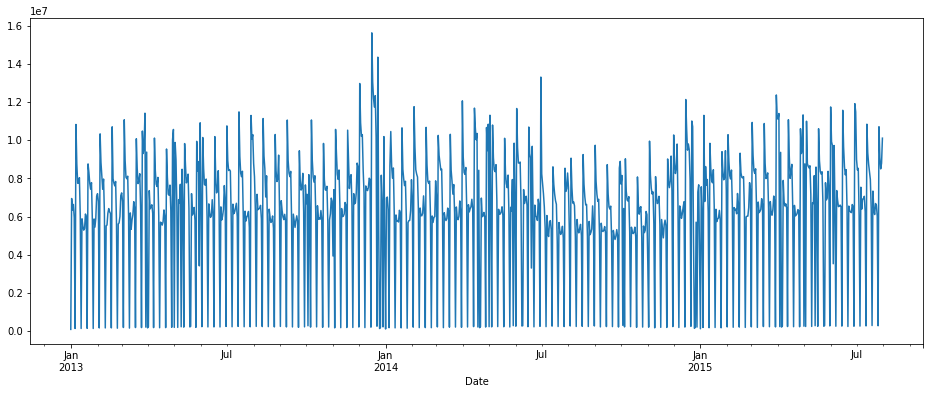

In [12]:
df_daily.plot(figsize=(16, 6));

What's a remedy for this mess?

Instead of plotting the most granular data we can "smooth" it

In [13]:
df_daily.rolling(window=3, center=True).mean().head()

Date
2013-01-01             NaN
2013-01-02    4.464961e+06
2013-01-03    6.645534e+06
2013-01-04    6.312789e+06
2013-01-05    4.244817e+06
Freq: D, Name: Sales, dtype: float64

`window`: how many values to "roll"?

`center`: is the value for the window the center or the start?

In [14]:
# if center=True, you need to wait window-1 days
df_daily.rolling(window=7, center=False).mean().head(8)

Date
2013-01-01             NaN
2013-01-02             NaN
2013-01-03             NaN
2013-01-04             NaN
2013-01-05             NaN
2013-01-06             NaN
2013-01-07    5.279455e+06
2013-01-08    6.515484e+06
Freq: D, Name: Sales, dtype: float64

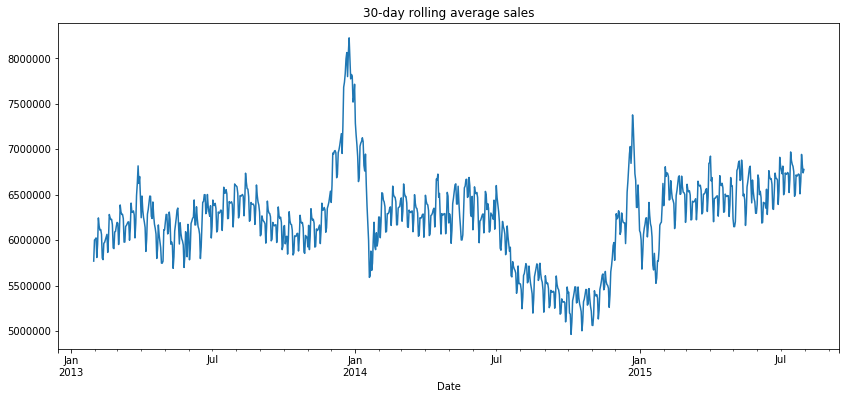

In [15]:
df_daily.rolling(window=30, center=False).mean().plot(figsize=(14, 6), title="30-day rolling average sales");

You can see the "cumulative mean" over time by using the "expanding mean"

In [16]:
quarterly_mean = df.set_index("Date")["Sales"].resample('Q').sum().rolling(window=1, center=False).mean()
rolling_4_quarterly_mean = df.set_index("Date")["Sales"].resample('Q').sum().rolling(window=4, center=False).mean()
expanding_quarterly_mean = df.set_index("Date")["Sales"].resample('Q').sum().expanding().mean()

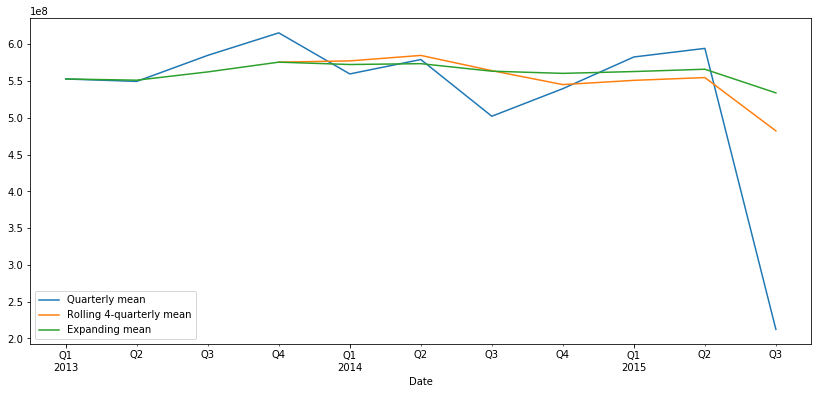

In [17]:
fig, ax = plt.subplots(figsize=(14, 6))
quarterly_mean.plot(label="Quarterly mean")
rolling_4_quarterly_mean.plot(label="Rolling 4-quarterly mean")
expanding_quarterly_mean.plot(label="Expanding mean")
ax.legend()
plt.show()

Another idea is to weight more recent observations higher when averaging.

We can use the "exponential-weighted mean" to introduce an exponential decay

In [18]:
exponential_mean = df.set_index("Date")["Sales"].resample('Q').sum().ewm(span=10).mean()

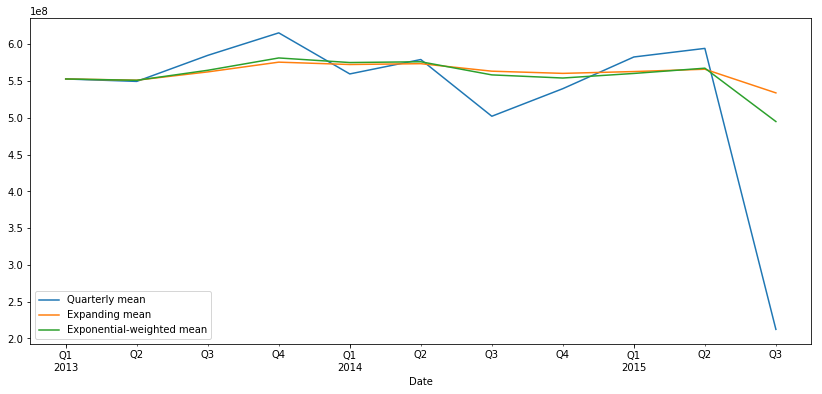

In [19]:
fig, ax = plt.subplots(figsize=(14, 6))
quarterly_mean.plot(label="Quarterly mean")
expanding_quarterly_mean.plot(label="Expanding mean")
exponential_mean.plot(label="Exponential-weighted mean")
ax.legend()
plt.show()

Note: if you are missing observations (e.g. Sundays) the rolling mean will average over the gaps!

i.e. it will average over Friday, Saturday and Monday.

Be aware of gaps in general!

### Stationarity

Many statistical forecasting models require our time series to be **stationary**.

This means a **constant mean and variance** (remember "homoscedasticity")

Why would non-stationarity be a problem for forecasting a time series?

How did we solve this problem before?

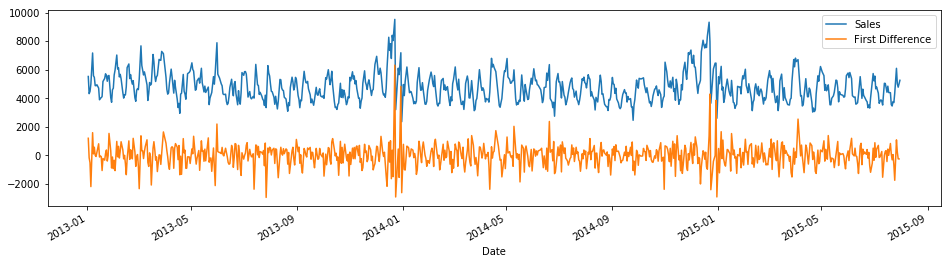

In [20]:
daily_diff = df_single_open["Sales"].diff(periods = 1)

fig, ax = plt.subplots(figsize=(16, 4))
df_single_open['Sales'].plot(label="Sales")
daily_diff.plot(label="First Difference")
ax.legend()
plt.show()

### Autocorrelation

For time series we're also interested in its **correlation with itself**

"How much do previous values in our time series inform the next one?"

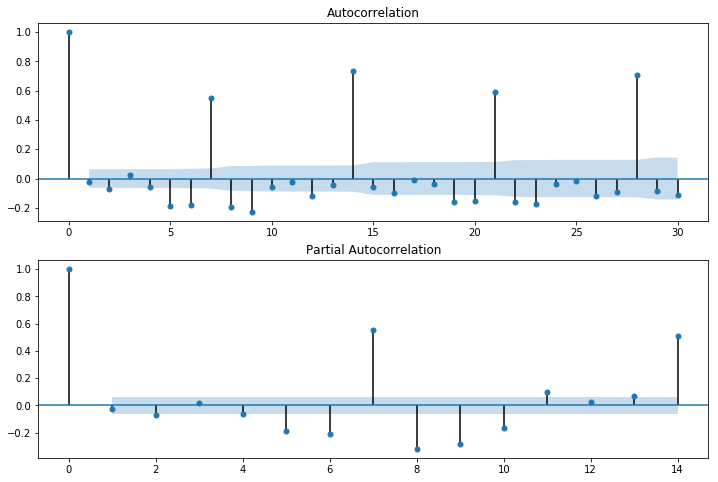

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df_daily, lags=30, ax=ax[0])
plot_pacf(df_daily, lags=14, ax=ax[1])

plt.show()

Why is it a problem?

- linear regression requires independence

- so using a regression approach with time series is a problem with autocorrelation

- we'll come back to how autocorrelation helps with forecasting

## Decomposing a Time Series

Let's look at another dataset, this time of average number of bus riders in Portland, Oregon.

In [22]:
bus = pd.read_csv("assets/data/bus.csv", names=["month", "avg_riders"], skiprows=1)
bus.head()

,month,avg_riders
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630


In [23]:
bus["date"] = pd.to_datetime(bus["month"], format="%Y-%m")
bus.head()

,month,avg_riders,date
0,1960-01,648,1960-01-01
1,1960-02,646,1960-02-01
2,1960-03,639,1960-03-01
3,1960-04,654,1960-04-01
4,1960-05,630,1960-05-01


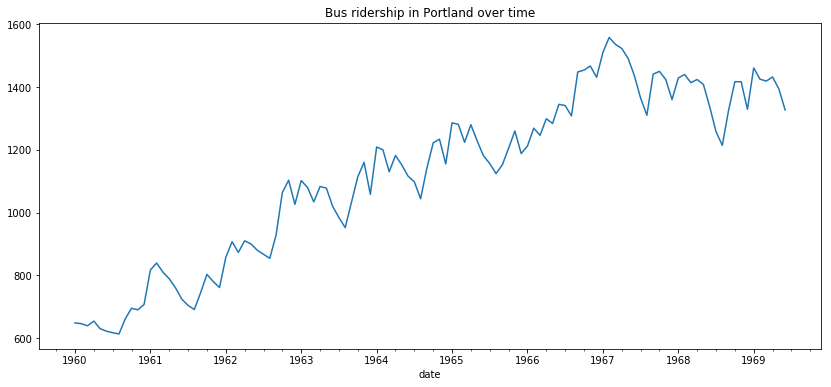

In [24]:
riders = bus.set_index("date")["avg_riders"]
riders.plot(figsize=(14, 6), title="Bus ridership in Portland over time");

What do we think?

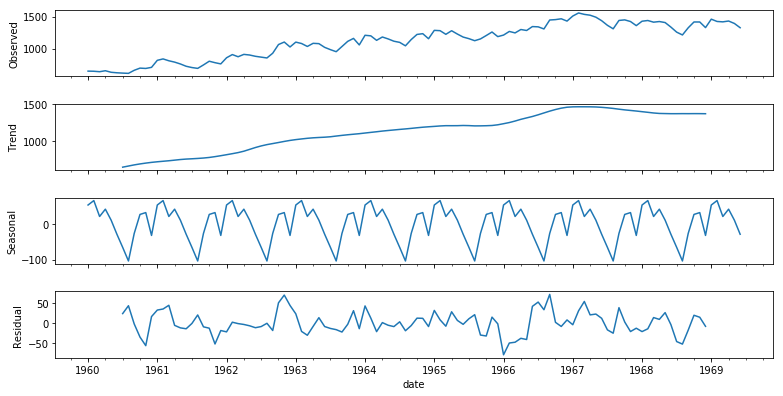

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(riders)
fig = decomposition.plot()
fig.set_size_inches(12, 6);

## Forecasting

Forecasting time series models is similar to machine learning so far.

- we have inputs (previous values in our time series)

- we are predicting known outputs

- we are interested in our "out of sample" performance on unseen data

- how are our train-test splits going to be different?

As we saw, for successful modelling we want a **fixed mean** and **fixed variance**

If you think about the intuition, if we don't know how our time series behaves "typically" it's hard to forecast!

So we want **stationarity**

We can use the Dickey-Fuller test whose null hypothesis is that our time series is **not** stationary

In [26]:
from statsmodels.tsa.stattools import adfuller

adfuller(riders)

(-1.5365971444531583,
 0.5153358797821742,
 12,
 101,
 {'1%': -3.4968181663902103,
  '10%': -2.5822770483285953,
  '5%': -2.8906107514600103},
 1028.4238367341432)

p-value is 0.51 which means we have no real evidence that our series is stationary

If we don't have it... we'll have to make it!

## ARIMA

Auto-Regressive Integrated Moving Average

"Auto-regressive": "values depend on past values"

"Integrated": "time series is not stationary and needs differencing"

"Moving average": "use previous errors as they are also informative"

You need to choose some parameters:

`p`: how much lag in the auto-regressive term? (how far back should I go?) (AR) - this is the autocorrelation plot of where the line enters the non-significant zone

`d`: differencing term (how much differencing to make it stationary?) (I)

`q`: how much lag to add to the error terms (MA) - like p, but uses partial autocorrelation

ARIMA is just a family of models, with many extensions

- "SARIMA": seasonal ARIMA

- "ARIMAX": ARIMA with the ability to add additional features

- "SARIMAX": combination of the two

In [27]:
train = riders["1960":"1965"] # 6 years
test = riders["1966":"1968"] # 3 years

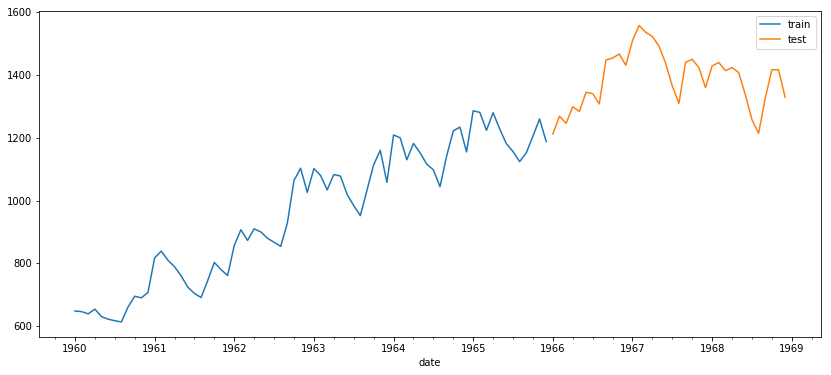

In [28]:
fig, ax = plt.subplots(figsize=(14, 6))

train.plot(ax=ax, label="train")
test.plot(ax=ax, label="test")
ax.legend()

plt.show()

In [29]:
import statsmodels as sm

sm.__version__

'0.9.0'

In [32]:
import statsmodels.api as sm
import datetime

model = sm.tsa.SARIMAX(train, order=(2, 1, 1), seasonal_order=(1, 1, 0, 12)).fit()
y_pred = model.predict(start=datetime.datetime(1966, 1, 1), end=datetime.datetime(1968, 12, 1))
# order p is how many lags in autocorrelate
# order d is how many times to difference the data to make it stationary
# order q is how many lags for partial autocorrelate
# exog to pass other DF columns

# just do an arima if no seasonality

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


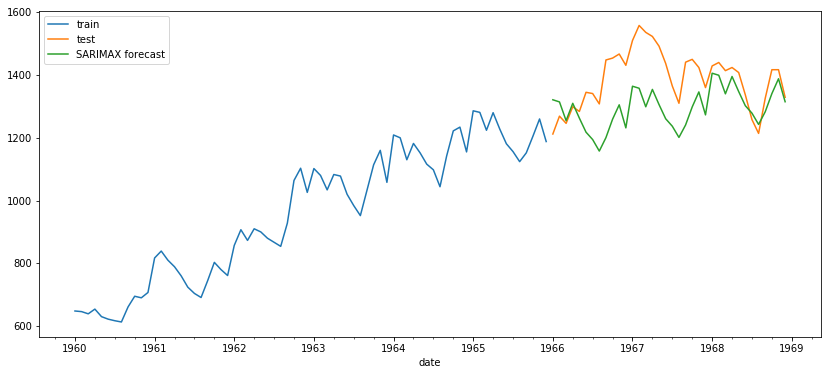

In [33]:
fig, ax = plt.subplots(figsize=(14, 6))

train.plot(ax=ax, label="train")
test.plot(ax=ax, label="test")
y_pred.plot(ax=ax, label="SARIMAX forecast")
ax.legend()

plt.show()

## Closing thoughts / What next?

- ARIMA models require tuning those parameters (further reading in README.md)

- you can understand a lot about time series from simple plots (by day, by month etc.)

- time series forecasting is **hard**

- traditional approaches to time series are more mature than "machine learning for time series"

_"The forecasting accuracy of ML forecasting methods is lower than the worst of statistical ones while the accuracy of more than half the ML methods is lower than a random walk"_

![](assets/images/ml_vs_time_series.jpg)

<small>Source: <a href="https://twitter.com/MScDigital/status/984725381394690048">https://twitter.com/MScDigital/status/984725381394690048</a></small>

### What else is available?

- if you want to read more about time series analysis, look to finance and econometrics, not ML

- the machine learning approach is to predict time series with deep neural networks (black boxes)

## Exercise